# 渋滞予測モデルの作成

In [1]:
import japanize_matplotlib
import joblib
import jpholiday
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from tqdm.notebook import tqdm

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
tqdm.pandas()

exp_no = 'final'
target = 'target_speed_diff'

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(0)

In [3]:
K = 4
kfold_valid = {
    1: ('2021-04-01', '2021-08-01'),
    2: ('2021-08-01', '2021-12-01'),
    3: ('2021-12-01', '2022-04-01'),
    4: ('2022-04-01', '2022-08-01'),
}
use_past_days = 0

## データ読み込みと結合

In [4]:
road = pd.read_csv('input/train/road.csv', 
                   dtype={'start_code':'str', 'end_code':'str'})
print(road.shape)
road.head()

(79, 18)


,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code
0,大泉ＪＣＴ,所沢,1110210,1800006,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.90,下り,0.0,9.4,100,1800
1,京葉道路・館山自動車道接続部,市原,1130001,1130006,12,12,35.55136,35.49471,140.143014,140.094986,2.0,2.0,39.17,下り,35.7,43.7,100,1130
2,市原,京葉道路・館山自動車道接続部,1130006,1130001,12,12,35.49471,35.55136,140.094986,140.143014,2.0,2.0,39.17,上り,43.7,35.7,100,1130
3,市原,姉崎袖ヶ浦,1130006,1130016,12,12,35.49471,35.42603,140.094986,140.045153,2.0,2.0,46.27,下り,43.7,53.7,100,1130
4,姉崎袖ヶ浦,市原,1130016,1130006,12,12,35.42603,35.49471,140.045153,140.094986,2.0,2.0,46.27,上り,53.7,43.7,100,1130


In [5]:
search_data = pd.read_csv('input/train/search_data.csv', 
                          parse_dates=['datetime'], 
                          dtype={'start_code':'str', 'end_code':'str'})

# ドラぷらデータ当日分を使用するため、1日前と紐付ける
search_data['datetime'] -= pd.to_timedelta(1, 'd')

print(search_data.shape)
search_data.head()

(910080, 4)


,datetime,start_code,end_code,search_1h
0,2021-04-07 00:00:00,1110210,1800006,15.0
1,2021-04-07 01:00:00,1110210,1800006,6.0
2,2021-04-07 02:00:00,1110210,1800006,3.0
3,2021-04-07 03:00:00,1110210,1800006,26.0
4,2021-04-07 04:00:00,1110210,1800006,31.0


In [6]:
search_unspec_data = pd.read_csv('input/train/search_unspec_data.csv', 
                                 parse_dates=['date'],
                                 dtype={'start_code':'str', 'end_code':'str'})
search_unspec_data['date'] = search_unspec_data['date'].dt.date

# ドラぷらデータ当日分を使用するため、1日前と紐付ける
search_unspec_data['date'] -= pd.to_timedelta(1, 'd')

print(search_unspec_data.shape)
search_unspec_data.head()

(37920, 4)


,date,start_code,end_code,search_unspec_1d
0,2021-04-07,1110210,1800006,3448.0
1,2021-04-08,1110210,1800006,2992.0
2,2021-04-09,1110210,1800006,2970.0
3,2021-04-10,1110210,1800006,2992.0
4,2021-04-11,1110210,1800006,2974.0


In [7]:
train = pd.read_csv('input/train/train.csv', 
                    parse_dates=['datetime'],
                    dtype={'start_code':'str', 'end_code':'str'})
train['date'] = train['datetime'].dt.date
print(train.shape)
train.head()

(910080, 8)


,datetime,start_code,end_code,OCC,allCars,speed,is_congestion,date
0,2021-04-08 00:00:00,1110210,1800006,2.083333,510,80.712329,0,2021-04-08
1,2021-04-08 01:00:00,1110210,1800006,1.500000,433,81.730415,0,2021-04-08
2,2021-04-08 02:00:00,1110210,1800006,1.333333,366,81.288828,0,2021-04-08
3,2021-04-08 03:00:00,1110210,1800006,1.500000,426,82.953162,0,2021-04-08
4,2021-04-08 04:00:00,1110210,1800006,1.833333,498,82.430862,0,2021-04-08


In [8]:
df = pd.merge(train, road, on=['start_code', 'end_code'], how='left')
df = pd.merge(df, search_data, on=['datetime', 'start_code', 'end_code'], how='left')
df = pd.merge(df, search_unspec_data, on=['date', 'start_code', 'end_code'], how='left')

## 特徴量作成

In [9]:
# 区間
df['section'] = df['start_code'] + '-' + df['end_code']

# 区間長
df['direction_code'] = df['direction'].map({'上り':-1, '下り':1})
df['section_length'] = df.eval('direction_code * (end_KP - start_KP)')

# 日付・時間帯
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

holiday = df[['datetime']].drop_duplicates()
holiday['tomorrow'] = holiday['datetime'] + pd.to_timedelta(1, 'd')
holiday['tomorrow_weekday'] = holiday['tomorrow'].dt.weekday
holiday['is_tomorrow_holiday'] = holiday['tomorrow'].map(jpholiday.is_holiday)
holiday['holiday_flag'] = holiday.eval(
    "tomorrow_weekday in (5, 6) or is_tomorrow_holiday"
)

df = pd.merge(df, holiday[['datetime', 'tomorrow_weekday', 'holiday_flag']], on=['datetime'], how='inner')
print(df.shape)

(910080, 34)


In [10]:
past_cols = ['OCC', 'allCars', 'speed', 'is_congestion', 'search_1h', 'search_unspec_1d', 'tomorrow_weekday']
past_df = df[['datetime', 'start_code', 'end_code'] + past_cols].copy()

In [11]:
for i in range(1, use_past_days+1):
    past_df['datetime'] -= pd.to_timedelta(-1, 'd')
    df = pd.merge(df, past_df, on=['datetime', 'start_code', 'end_code'], how='inner', 
                  suffixes=['', f'_{i}days_before'])

In [12]:
# 目的変数
target_df = df[['datetime', 'start_code', 'end_code', 'speed', 'is_congestion']].copy()
target_df['datetime'] -= pd.to_timedelta(1, 'd')
target_df.rename(columns={'speed':'target_speed', 'is_congestion':'target_flag'}, inplace=True)
df = pd.merge(df, target_df, on=['datetime', 'start_code', 'end_code'], how='inner')
df['target_speed_diff'] = df.eval("target_speed - speed")

In [13]:
train_dfs = {}
valid_dfs = {}
for k in range(1, K+1):
    valid_date_mask = df.eval("@kfold_valid[@k][0] <= datetime < @kfold_valid[@k][1]")
    train_dfs[k] = df.loc[~valid_date_mask]
    valid_dfs[k] = df.loc[valid_date_mask]

In [14]:
# 時間帯ごとの集計特徴量
for k in range(1, K+1):
    df_tc = train_dfs[k]\
    .groupby(['start_code', 'end_code', 'holiday_flag', 'hour'], as_index=False)\
    .agg(
        congestion_rate = ('is_congestion', 'mean'),
        cars_mean = ('allCars', 'mean'),
        cars_median = ('allCars', 'median'),
        cars_max = ('allCars', 'max'),
        cars_min = ('allCars', 'min'),
        occ_mean = ('OCC', 'mean'),
        occ_median = ('OCC', 'median'),
        occ_max = ('OCC', 'max'),
        occ_min = ('OCC', 'min'),
        speed_mean = ('speed', 'mean'),
        speed_min = ('speed', 'min'),
        speed_median = ('speed', 'median'),
        speed_max = ('speed', 'max'),
    )
    df_tc.to_csv(f'submit/src/TCstats_fold{k}of{K}.csv', index=False)

In [15]:
numerical_features = [
    'month',
    'day',
    'hour',
    'allCars',
    'OCC',
    'speed',
    'cars_mean',
    'cars_median',
    'cars_max',
    'cars_min',
    'occ_mean',
    'occ_median',
    'occ_max',
    'occ_min',
    'speed_mean',
    'speed_min',
    'speed_median',
    'speed_max',
    'start_lat',
    'end_lat',
    'start_lng',
    'end_lng',
    'start_degree',
    'end_degree',
    'KP',
    'start_KP',
    'end_KP',
    'section_length',
    'limit_speed',
    'search_1h',
    'search_unspec_1d',
    'holiday_flag',
    'congestion_rate',
    'tomorrow_weekday'
]
numerical_features += [f'{col}_{i}days_before' 
                       for i in range(1, use_past_days+1) 
                       for col in past_cols]
categorical_features = [
    'section',
    # 'start_pref_code',
    # 'end_pref_code',
    'direction',
    'road_code'
]
features = numerical_features + categorical_features

## モデル学習

In [16]:
def lgb_train(fold_num):
    print(f'========== Fold {fold_num} ==========')

    train_df = train_dfs[fold_num]
    valid_df = valid_dfs[fold_num]
    df_tc = pd.read_csv(f'submit/src/TCstats_fold{fold_num}of{K}.csv', 
                        dtype={'start_code':'str', 'end_code':'str'})
    train_df = pd.merge(train_df, df_tc, on=['start_code', 'end_code', 'holiday_flag', 'hour'], how='left')
    valid_df = pd.merge(valid_df, df_tc, on=['start_code', 'end_code', 'holiday_flag', 'hour'], how='left')

    train_df = train_df.astype({col:'category' for col in categorical_features})
    valid_df = valid_df.astype({col:'category' for col in categorical_features})
    params= {
        'objective': 'regression',
        'learning_rate':0.01, 
        'n_estimators': 10000,
        'importance_type':'gain',
    }
    model = lgb.LGBMRegressor(**params)

    eval_results = {}
    model.fit(train_df[features], train_df[target],
              eval_set=[(train_df[features], train_df[target]),(valid_df[features], valid_df[target])],
              eval_names=['train', 'valid'],
              eval_metric='mse',
              callbacks=[
                  lgb.callback.record_evaluation(eval_results),
                  lgb.early_stopping(stopping_rounds=100, verbose=True)
              ])
    print('best iteration:', model.best_iteration_)

    # plot loss curve
    plt.plot(eval_results['train']['l2'], label='train')
    plt.plot(eval_results['valid']['l2'], label='valid')
    plt.xlabel('Iteration')
    plt.ylabel('MAE')
    plt.title(f'fold {fold_num}')
    plt.legend()
    plt.show()

    result = valid_df[['speed', 'target_flag']].copy()
    result['pred_speed_diff'] = model.predict(valid_df[features])
    result['prediction'] = result.eval("speed + pred_speed_diff < 40.0")

    print('recall:', round(recall_score(result['target_flag'], result['prediction']), 4))
    print('precision:', round(precision_score(result['target_flag'], result['prediction']), 4))
    print('f1_score:', round(f1_score(result['target_flag'], result['prediction']), 4))

    lgb.plot_importance(model.booster_)
    plt.show()
    return model, result

========== Fold 1 ==========


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3097]	train's l2: 13.5405	valid's l2: 16.3719
best iteration: 3097


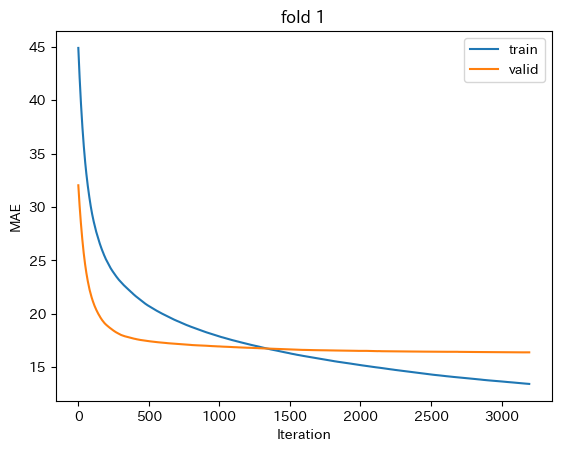

recall: 0.0341
precision: 0.5385
f1_score: 0.0642


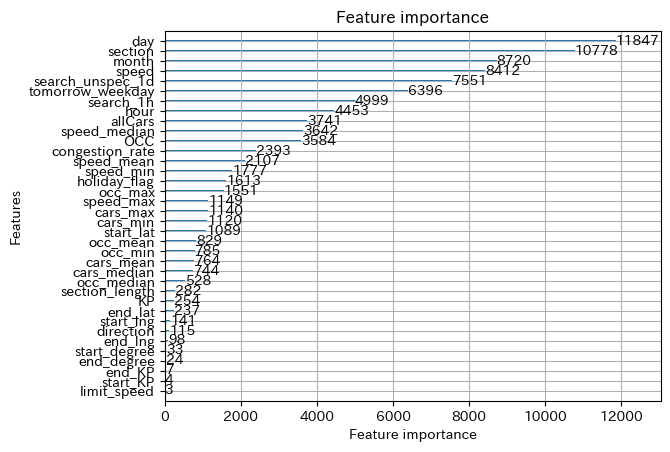

========== Fold 2 ==========


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[304]	train's l2: 22.3217	valid's l2: 23.7536
best iteration: 304


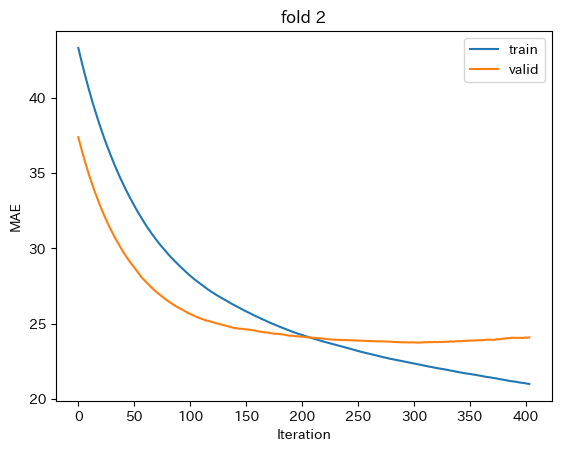

recall: 0.0
precision: 0.0
f1_score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


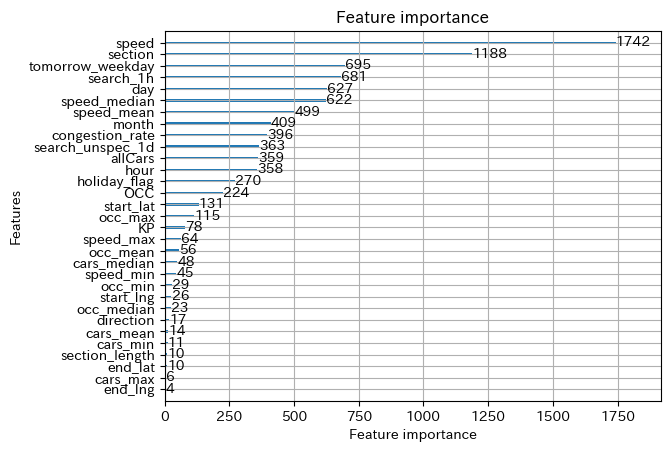

========== Fold 3 ==========


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	train's l2: 19.4707	valid's l2: 40.9845
best iteration: 161


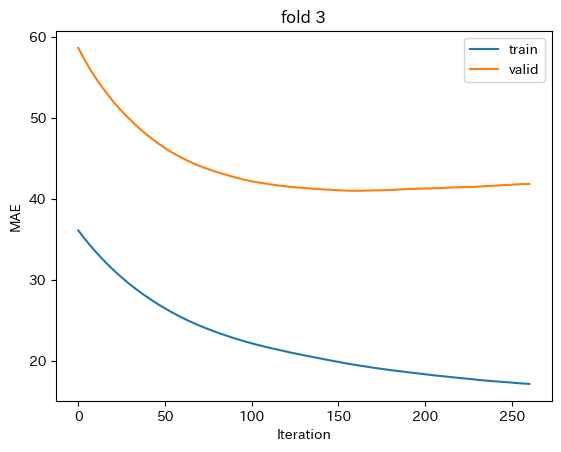

recall: 0.0218
precision: 0.3393
f1_score: 0.041


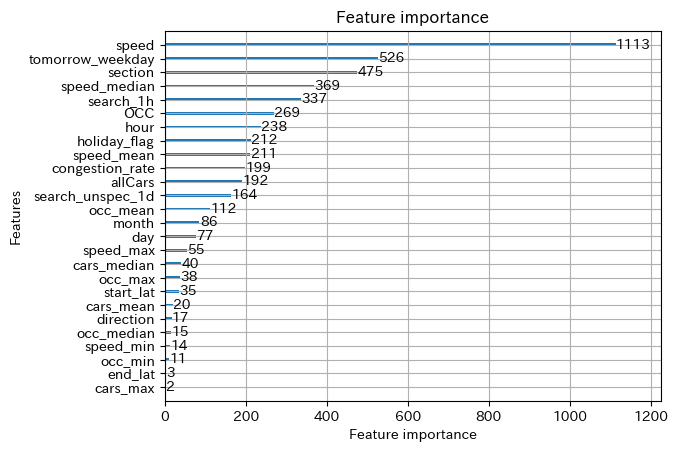

========== Fold 4 ==========


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	train's l2: 25.3091	valid's l2: 26.8741
best iteration: 163


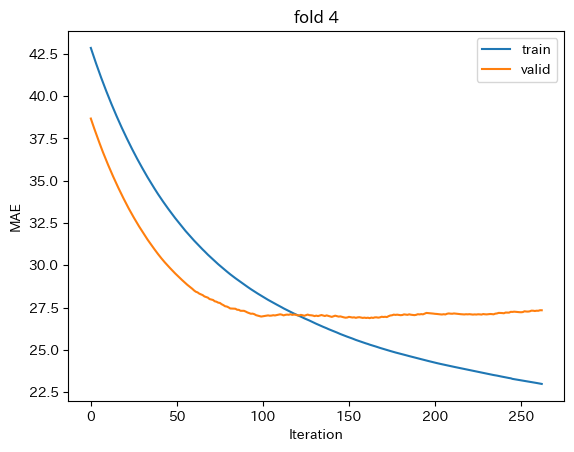

recall: 0.6378
precision: 0.9813
f1_score: 0.7731


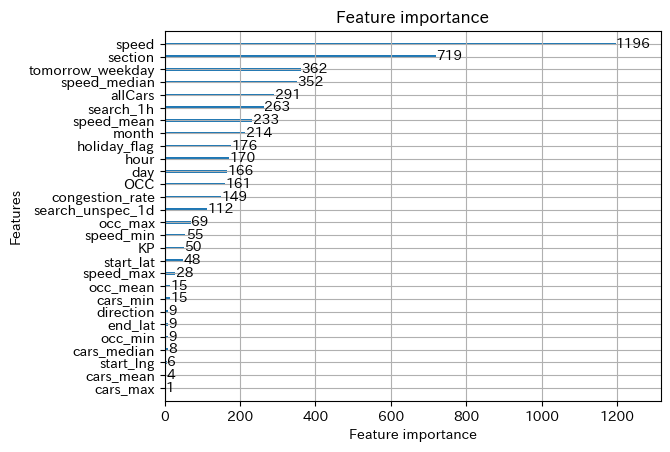

In [17]:
results = []
for k in range(1, K+1):
    model, result = lgb_train(k)
    results.append(result)
    joblib.dump(model, f'submit/model/model_{k}of{K}.pkl')

In [18]:
result_df = pd.concat(results)
print('CV score:', round(f1_score(result_df['target_flag'], result_df['prediction']), 4))

CV score: 0.4476
